In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
!pip install simpletransformers
from simpletransformers.language_representation import RepresentationModel
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Load and Save Utility

In [ ]:
import pickle
import joblib

#Load Save Pickle Utility
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)

Declare Parameters

In [ ]:
#Parameters
model_type = 'cnn'         # 'lstm','cnn'
embedding_type = 'triple'  #  'triple' ,'double','bert'
dataset_name = 'restaraunt'         # 'laptop', 'restaraunt'

Preprocess Dataset

In [ ]:
def preprocess_dataset(filepath):
  file = open(filepath)
  #file = open('/content/drive/MyDrive/NLP_PROJECT/Laptop_Processed/train.txt')
  examples = file.readlines()
  examples = [example[:-1] for example in examples]
  file.close()
  dataset_text = [example.split('####')[1] for example in examples]
  tokenized_dataset_text = [sentence.split(" ") for sentence in dataset_text]
  dataset = []
  for tokenized_sentence in tokenized_dataset_text:
    terms = []
    labels = []
    sentiment = []
    count = 0
    for token in tokenized_sentence:
      if '==' in token:
        splitting = ['=','O']
      else:
        splitting = token.split('=')
      terms.append(splitting[0])
      #print(splitting)
      if splitting[1][0] == 'T':
        if count == 0 or labels[-1] == 'O':
          labels.append('B')
        else:
          labels.append('I')
        sentiment.append(splitting[1][2:])
      else:
        labels.append('O')
        sentiment.append('NA')
      count +=1
    dataset.append({'terms': terms.copy(), 'labels':labels.copy(), 'sentiment' : sentiment.copy()})
  return dataset

In [ ]:
laptop_train_set = preprocess_dataset('/content/drive/MyDrive/NLP_PROJECT_2/Laptop_Processed/train.txt')
laptop_test_set = preprocess_dataset('/content/drive/MyDrive/NLP_PROJECT_2/Laptop_Processed/test.txt')

restaraunt_train_set = preprocess_dataset('/content/drive/MyDrive/NLP_PROJECT_2/Restaraunt_Processed/train.txt')
restaraunt_test_set = preprocess_dataset('/content/drive/MyDrive/NLP_PROJECT_2/Restaraunt_Processed/test.txt')



In [ ]:
save('/content/drive/MyDrive/NLP_PROJECT_2/Laptop_Processed/train.pkl',laptop_train_set)
save('/content/drive/MyDrive/NLP_PROJECT_2/Laptop_Processed/test.pkl',laptop_test_set)

save('/content/drive/MyDrive/NLP_PROJECT_2/Restaraunt_Processed/train.pkl',restaraunt_train_set)
save('/content/drive/MyDrive/NLP_PROJECT_2/Restaraunt_Processed/test.pkl',restaraunt_test_set)


In [ ]:
laptop_train_set = load('/content/drive/MyDrive/NLP_PROJECT_2/Laptop_Processed/train.pkl')
laptop_test_set = load('/content/drive/MyDrive/NLP_PROJECT_2/Laptop_Processed/test.pkl')

restaraunt_train_set = load('/content/drive/MyDrive/NLP_PROJECT_2/Restaraunt_Processed/train.pkl')
restaraunt_test_set = load('/content/drive/MyDrive/NLP_PROJECT_2/Restaraunt_Processed/test.pkl')


In [ ]:
if dataset_name == 'restaraunt':
  current_train_dataset = restaraunt_train_set
  current_test_dataset = restaraunt_test_set
else:
  current_train_dataset = laptop_train_set
  current_test_dataset = laptop_test_set

In [ ]:
def prepare_sentences(dataset):
  filepath = 'input_sent.txt'
  file = open(filepath,'w+')
  for i in range(len(dataset)):
    l = ' '.join(list(map(lambda x : x.lower(),dataset[i]['terms'])))
    file.write(l+'\n')
  file.close()
  return filepath

In [ ]:
def prepare_sentences_list(dataset):
  output_list = []
  for i in range(len(dataset)):
    l = ' '.join(list(map(lambda x : x.lower(),dataset[i]['terms'])))
    output_list.append(l)
  return output_list

In [ ]:
prepare_sentences(current_train_dataset)

'input_sent.txt'

In [ ]:
#Glove Pretrained
# !cd /content/
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/glove.6B.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/NLPA3/corpora')

In [ ]:
#Preparing GLove_Vectors
# glove_model = {}
# with open('/content/drive/MyDrive/NLPA3/corpora/glove.6B.300d.txt','r',encoding='utf-8') as file:
#   for line in file:
#     splits = line.split()
#     key = splits[0]
#     vector_representation = np.asarray(splits[1:],np.float32)
#     glove_model[key] = vector_representation

Calculating Max Length of Sentence for padding and Indexing all words and Tags

In [ ]:
max_len = 0
for sample in current_train_dataset:
  if len(sample['terms']) > max_len:
    max_len = len(sample['terms'])

#max_len = 83

In [ ]:
if embedding_type != 'bert':
  glove_model = load('/content/drive/MyDrive/NLPA3/glove_model.pkl')

In [ ]:
#creating list of sentences for getting Bert representation
if embedding_type!='double':
  sentences = prepare_sentences_list(current_train_dataset)
  test_sentences = prepare_sentences_list(current_test_dataset)
  #defining bert encoder for embedding and encoding bert representation
  encoder = RepresentationModel(
      model_type = "bert",
      model_name = 'bert-base-uncased',
      use_cuda = True
  )
  bert_vectors = []
  for sentence in sentences:
    word_vector = encoder.encode_sentences([sentence],combine_strategy = None)
    word_vector = pad_sequences(maxlen=max_len, sequences=word_vector[:,1:-1,:], padding="post", value=np.zeros(word_vector.shape[-1]))
    bert_vectors.append(word_vector)
  bert_vectors = np.concatenate(bert_vectors,axis=0)
  test_bert_vectors = []
  for sentence in test_sentences:
    word_vector = encoder.encode_sentences([sentence],combine_strategy = None)
    word_vector = pad_sequences(maxlen=max_len, sequences=word_vector[:,1:-1,:], padding="post", value=np.zeros(word_vector.shape[-1]))
    test_bert_vectors.append(word_vector)
  test_bert_vectors = np.concatenate(test_bert_vectors,axis = 0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
if embedding_type != 'bert':
  !pip install fasttext
  import fasttext
  embedding = fasttext.train_unsupervised('input_sent.txt')

In [ ]:
all_words = []
for sample in current_train_dataset:
  all_words += sample['terms']
all_words = list(set(all_words))
word_indices = {word : index+1 for index,word in enumerate(all_words)}



In [ ]:
if embedding_type != 'bert':
  combined_embedding = {}
  for word in all_words:
    general = glove_model[word] if word in glove_model else np.zeros((300,))
    domain = embedding[word] if word in embedding else np.zeros((100,))
    combo = np.concatenate((general,domain))
    combined_embedding[word_indices[word]] = combo
  combined_embedding[0] = np.zeros((400,))

In [ ]:
tag_indices = {'B':0, 'I':1, 'O':2}
rev_tag_indices = {0:'B', 1:'I', 2:'O'}

Padding Sentence Sequenc

In [ ]:
X_train = [[word_indices[t] for t in sample['terms']] for sample in current_train_dataset]
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=0)

X_test = [[word_indices[t] if t in word_indices else 0 for t in sample['terms']] for sample in current_test_dataset]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=0)

if embedding_type != 'bert':
  X_train = [[combined_embedding[t] for t in sample] for sample in X_train]
  X_train = np.array(X_train)
  X_test = [[combined_embedding[t] for t in sample] for sample in X_test]
  X_test = np.array(X_test)
  if embedding_type == 'triple':
    X_train = np.concatenate([X_train,bert_vectors],axis=2)
    X_test = np.concatenate([X_test,test_bert_vectors],axis=2)
else:
  X_train = bert_vectors
  X_test = test_bert_vectors
y_train = [[tag_indices[t] for t in sample['labels']] for sample in current_train_dataset]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag_indices['O'])
y_train = [to_categorical(i, num_classes=3) for i in y_train]

y_test = [[tag_indices[t] for t in sample['labels']] for sample in current_test_dataset]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag_indices['O'])
y_test = [to_categorical(i, num_classes=3) for i in y_test]


LSTM/CNN Model for Labelling

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,Conv1D,concatenate
if model_type =='lstm':
  input = Input(shape=X_train.shape[1:])
  model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(input)  # variational biLSTM
  out = TimeDistributed(Dense(3, activation="softmax"))(model)  # a dense layer as suggested by neuralNer

  model = Model(input, out)
  model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics='acc')
  model.summary()
else:
  input = Input(shape=X_train.shape[1:])
  model1 = Conv1D(256,3,strides = 1,activation = 'relu',padding = 'same')(input)
  model2 = Conv1D(256,5,strides = 1,activation = 'relu',padding = 'same')(input)
  model = concatenate([model1,model2])
  model = Conv1D(512,5,strides = 1,activation = 'relu',padding = 'same')(model)
  model = Conv1D(512,5,strides = 1,activation = 'relu',padding = 'same')(model)
  model = Conv1D(512,5,strides = 1,activation = 'relu',padding = 'same')(model)
  model = Dense(25, activation="relu")(model) 
  out = Dense(3, activation="softmax")(model)  # a dense layer as suggested by neuralNer

  model = Model(input, out)
  model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics='acc')
  model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 75, 1168)]   0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 75, 256)      897280      ['input_8[0][0]']                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 75, 256)      1495296     ['input_8[0][0]']                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 75, 512)      0           ['conv1d_15[0][0]',              
                                                                  'conv1d_16[0][0]']        

In [ ]:
#Save X,y for each embedding
save('/content/drive/MyDrive/NLP_PROJECT/Final/Embeddings/X_train_'+embedding_type+'_'+dataset_name+'.pkl',X_train)
save('/content/drive/MyDrive/NLP_PROJECT/Final/Embeddings/X_test_'+embedding_type+'_'+dataset_name+'.pkl',X_test)
save('/content/drive/MyDrive/NLP_PROJECT/Final/Embeddings/y_train_' + dataset_name+'.pkl',y_train)
save('/content/drive/MyDrive/NLP_PROJECT/Final/Embeddings/y_test_' + dataset_name+'.pkl',y_test)

In [ ]:
#Fit Model
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.1, verbose=1)
hist = pd.DataFrame(history.history)

Epoch 1/10
77/77 [==============================] - 11s 107ms/step - loss: 0.2367 - acc: 0.9642 - val_loss: 0.0343 - val_acc: 0.9876
Epoch 2/10
77/77 [==============================] - 7s 91ms/step - loss: 0.0337 - acc: 0.9887 - val_loss: 0.0260 - val_acc: 0.9910
Epoch 3/10
77/77 [==============================] - 7s 87ms/step - loss: 0.0166 - acc: 0.9945 - val_loss: 0.0276 - val_acc: 0.9898
Epoch 4/10
77/77 [==============================] - 6s 82ms/step - loss: 0.0077 - acc: 0.9974 - val_loss: 0.0459 - val_acc: 0.9909
Epoch 5/10
77/77 [==============================] - 6s 79ms/step - loss: 0.0054 - acc: 0.9985 - val_loss: 0.0395 - val_acc: 0.9910
Epoch 6/10
77/77 [==============================] - 6s 79ms/step - loss: 0.0045 - acc: 0.9987 - val_loss: 0.0413 - val_acc: 0.9907
Epoch 7/10
77/77 [==============================] - 6s 79ms/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0394 - val_acc: 0.9920
Epoch 8/10
77/77 [==============================] - 6s 78ms/step - loss: 0.0019 -

In [ ]:
model.save('/content/drive/MyDrive/NLP_PROJECT/Final/Models/ATE/'+dataset_name+'_'+embedding_type+'_'+model_type+'.pkl')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_PROJECT/Final/Models/ATE/restaraunt_triple_cnn.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_PROJECT/Final/Models/ATE/restaraunt_triple_cnn.pkl/assets


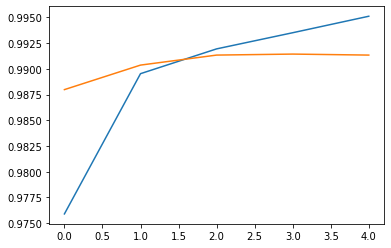

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist["acc"],label="Train Accuracy")
plt.plot(hist["val_acc"],label="Test Accuracy")
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/NLP_PROJECT/Final/Models/ATE/'+dataset_name+'_'+embedding_type+'_'+model_type+'.pkl')

In [ ]:
model.evaluate(X_test,np.array(y_test))

25/25 [==============================] - 3s 100ms/step - loss: 0.0645 - acc: 0.9777


[0.06445328891277313, 0.9776999950408936]

In [ ]:
train_pred = np.argmax(model.predict(X_train),axis = 2)
train_target = np.argmax(np.array(y_train),axis=2)

In [ ]:
pred = np.argmax(model.predict(X_test),axis=2)
target = np.argmax(np.array(y_test),axis=2)

In [ ]:
y_t = []
y_h = []
for i in range(pred.shape[0]):
  for j in range(pred.shape[1]):
    y_t.append(target[i,j])
    y_h.append(pred[i,j])

In [ ]:
y_t = []
y_h = []
for i in range(train_pred.shape[0]):
  for j in range(train_pred.shape[1]):
    y_t.append(train_target[i,j])
    y_h.append(train_pred[i,j])

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
def tag_wise_metrics(y_true, y_pred, target_names):
  print(classification_report(y_true, y_pred, target_names=target_names))

tag_wise_metrics(y_t, y_h, ['B','I','O'])

              precision    recall  f1-score   support

           B       0.84      0.73      0.78      1121
           I       0.84      0.57      0.68       502
           O       0.99      1.00      1.00     58377

    accuracy                           0.99     60000
   macro avg       0.89      0.77      0.82     60000
weighted avg       0.99      0.99      0.99     60000



In [ ]:
pred_labels = []
for i in range(pred.shape[0]):
  pred_labels.append(list(map( lambda x: rev_tag_indices[x],pred[i])))
print(pred_labels)

In [ ]:
target_labels = [list(map(lambda x:rev_tag_indices[x],pred))np.argmax(np.array(y_test),axis = 2)

In [ ]:
def find_scores(y_true, y_pred, type_1 = 'micro'):
  print("Precision of type : ", type_1)
  print(precision_score(y_true, y_pred, average=type_1))
  print("Recall of type : ", type_1)
  print(recall_score(y_true, y_pred, average=type_1))
  print("F1-Score of type : ", type_1)
  print(f1_score(y_true, y_pred, average=type_1))

In [ ]:
find_scores(y_t,y_h,'macro')

Precision of type :  macro
0.6563325280238598
Recall of type :  macro
0.6024282693740851
F1-Score of type :  macro
0.6235070127055947


In [ ]:
final_output = []
terms = [[t for t in sample['terms']] + [0]*(max_len-len(sample['terms'])) for sample in laptop_train_set]
pred_labels = [list(train_pred[i]) for i in range(train_pred.shape[0])]
pred_labels = [[rev_tag_indices[t] for t in sample]+ [0]*(max_len-len(sample)) for sample in pred_labels]
sentiments = [[t for t in sample['sentiment']] + [0]*(max_len-len(sample['sentiment'])) for sample in laptop_train_set]


In [ ]:
final = [[terms[i],pred_labels[i],sentiments[i]] for i in range(len(terms))]
final = pd.DataFrame(final,columns=["terms","aspect_labels","sentiments"])

In [ ]:
final.head()

,terms,aspect_labels,sentiments
0,"[i, charge, it, at, night, and, skip, taking, ...","[O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, ...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NEU, NA, ..."
1,"[i, bought, a, hp, pavilion, dv4-1222nr, lapto...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
2,"[the, tech, guy, then, said, the, service, cen...","[O, B, I, O, O, O, B, I, O, O, O, O, O, O, O, ...","[NA, NEU, NEU, NA, NA, NA, NEG, NEG, NA, NA, N..."
3,"[i, investigated, netbooks, and, saw, the, tos...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, 0, 0, 0, ..."
4,"[it, is, of, high, quality, ,, has, a, killer,...","[O, O, O, O, B, O, O, O, O, B, O, O, O, O, O, ...","[NA, NA, NA, NA, POS, NA, NA, NA, NA, POS, NA,..."


In [ ]:
save('/content/drive/MyDrive/NLP_PROJECT/Final/ATE/Predictions/laptop_train',final)